# Overview
# This project implements a deep learning pipeline to classify chest X-ray images into "Normal" and "Pneumonia" categories. The workflow includes data preprocessing, model training using pre-trained architectures (DenseNet121, EfficientNetB0, ResNet50), fine-tuning, and model evaluation with custom thresholds.

# Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing libraries

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121, EfficientNetB0, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# Ignore Warning

In [ ]:
import warnings
warnings.filterwarnings("ignore")

### Dataset Preparation
#### Unzipping and Organizing Data
- `Path Definitions': Define paths for the dataset (train, validation, and test directories).
- `Directory Check': Ensures required directories exist, otherwise raises an error.
- `Unzipping Dataset':Automatically unzips the dataset if not already unzipped.

# Importing Data

In [ ]:
# Step 1: Define the path to the zip file and output directory
zip_file_path = '/content/drive/MyDrive/chest_xray.zip'
output_directory = '/content/drive/MyDrive/chest_xray'

# Step 2: Check if the output directory already exists
if not os.path.exists(output_directory):
    print("Output directory not found. Unzipping the dataset...")
    !unzip -q "{zip_file_path}" -d "{output_directory}"
    print("Unzipping complete.")
else:
    print("Output directory already exists. Skipping the unzipping step.")

# Step 3: Verify the unzipping by listing the files in the output directory
print("Contents of the output directory:")
!ls "{output_directory}"

# Step 4: Define base_dir and paths for train, validation, and test directories
base_dir = os.path.join('/content/drive/MyDrive/chest_xray', 'chest_xray')
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

print("Directories set:")
print(f"Train directory: {train_dir}")
print(f"Validation directory: {val_dir}")
print(f"Test directory: {test_dir}")

# Check if these directories exist
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        print(f"{dir_path} exists.")
    else:
        print(f"Error: {dir_path} does not exist.")


Output directory already exists. Skipping the unzipping step.
Contents of the output directory:
chest_xray
Directories set:
Train directory: /content/drive/MyDrive/chest_xray/chest_xray/train
Validation directory: /content/drive/MyDrive/chest_xray/chest_xray/val
Test directory: /content/drive/MyDrive/chest_xray/chest_xray/test
/content/drive/MyDrive/chest_xray/chest_xray/train exists.
/content/drive/MyDrive/chest_xray/chest_xray/val exists.
/content/drive/MyDrive/chest_xray/chest_xray/test exists.


#### Image Augmentation
Data augmentation is performed to increase dataset diversity:
## `ImageDataGenerator` is used for operations like rotation, width/height shift, shear, zoom, horizontal flip, and brightness adjustment.

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [ ]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.2, 1.5]
)

test_datagen = ImageDataGenerator(rescale=1./255)


### Data Generators
- `train_generator`: Loads and augments training data.
- `validation_generator`: Prepares validation data with rescaling.
- `test_generator`: Prepares test data with rescaling and without shuffling.

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Visualization
- Sample Images: Displays sample images from the dataset.
- Data Distribution: Bar and pie charts visualize the distribution of Normal and Pneumonia samples in train, validation, and test datasets.


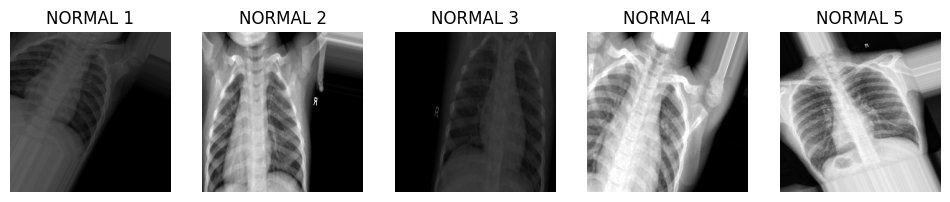

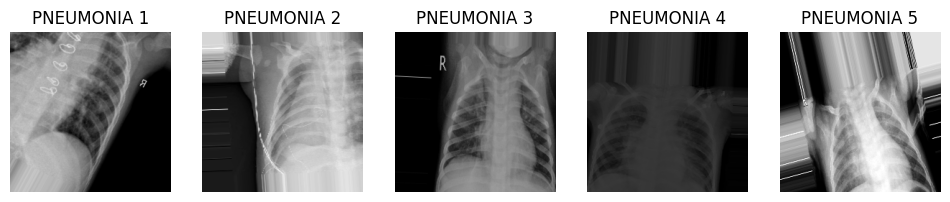

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_sample_images(generator, class_name, num_images=5):
    class_idx = generator.class_indices[class_name]
    images, labels = next(generator)
    class_images = images[labels == class_idx]

    plt.figure(figsize=(12, 12))
    for i in range(min(num_images, len(class_images))):
        plt.subplot(1, num_images, i+1)
        plt.imshow(class_images[i])
        plt.axis('off')
        plt.title(f"{class_name} {i+1}")
    plt.show()

# Display 5 sample images of 'NORMAL' and 'PNEUMONIA'
display_sample_images(train_generator, 'NORMAL', num_images=5)
display_sample_images(train_generator, 'PNEUMONIA', num_images=5)


Using image: /content/drive/MyDrive/chest_xray/chest_xray/train/NORMAL/IM-0527-0001.jpeg


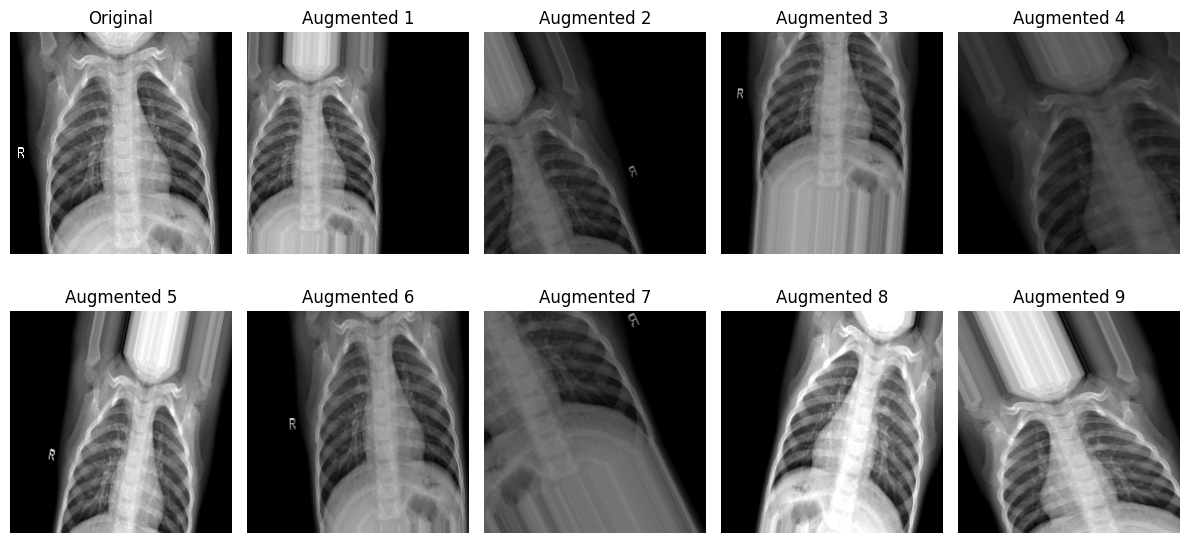

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Specify the folder and class to pick an image from
BASE_DIR = '/content/drive/MyDrive/chest_xray/chest_xray/train'
CLASS = 'NORMAL'
IMG_SIZE = (224, 224)

# Get a sample image path from the chosen folder
image_path = os.path.join(BASE_DIR, CLASS, os.listdir(os.path.join(BASE_DIR, CLASS))[0])
print(f"Using image: {image_path}")

# Load and preprocess the image
original_image = load_img(image_path, target_size=IMG_SIZE)
image_array = img_to_array(original_image).reshape((1,) + IMG_SIZE + (3,))

# Define the data augmentation generator
augmentation_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.2, 1.5]
)

# Generate augmented images
augmented_images = augmentation_gen.flow(image_array, batch_size=1)

# Plot the original image and a few augmented samples
plt.figure(figsize=(12, 6))

# Show the original image
plt.subplot(2, 5, 1)
plt.imshow(original_image)
plt.title("Original")
plt.axis("off")

# Generate and plot augmented images
for i in range(9):  # Generate 9 augmented images
    aug_img = next(augmented_images)[0].astype('uint8')
    plt.subplot(2, 5, i + 2)
    plt.imshow(aug_img)
    plt.axis("off")
    plt.title(f"Augmented {i+1}")

plt.tight_layout()
plt.show()


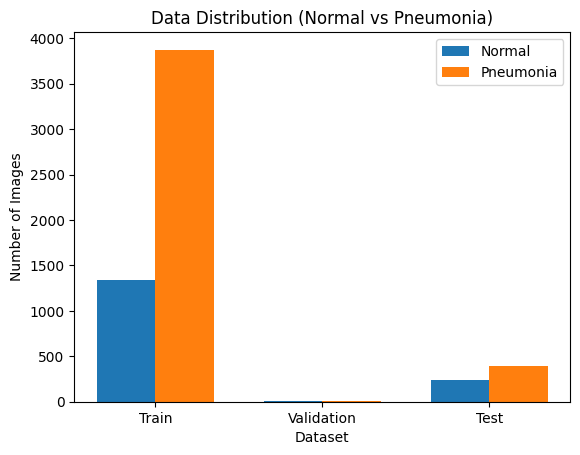

In [ ]:
import matplotlib.pyplot as plt
import os

def plot_data_distribution(train_dir, val_dir, test_dir):
    normal_train = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
    pneumonia_train = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
    normal_val = len(os.listdir(os.path.join(val_dir, 'NORMAL')))
    pneumonia_val = len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))
    normal_test = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
    pneumonia_test = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))

    categories = ['Train', 'Validation', 'Test']
    normal_counts = [normal_train, normal_val, normal_test]
    pneumonia_counts = [pneumonia_train, pneumonia_val, pneumonia_test]

    bar_width = 0.35
    index = np.arange(len(categories))

    plt.bar(index, normal_counts, bar_width, label='Normal')
    plt.bar(index + bar_width, pneumonia_counts, bar_width, label='Pneumonia')

    plt.xlabel('Dataset')
    plt.ylabel('Number of Images')
    plt.title('Data Distribution (Normal vs Pneumonia)')
    plt.xticks(index + bar_width / 2, categories)
    plt.legend()

    plt.show()

# Plot data distribution for train, validation, and test sets
plot_data_distribution(train_dir, val_dir, test_dir)


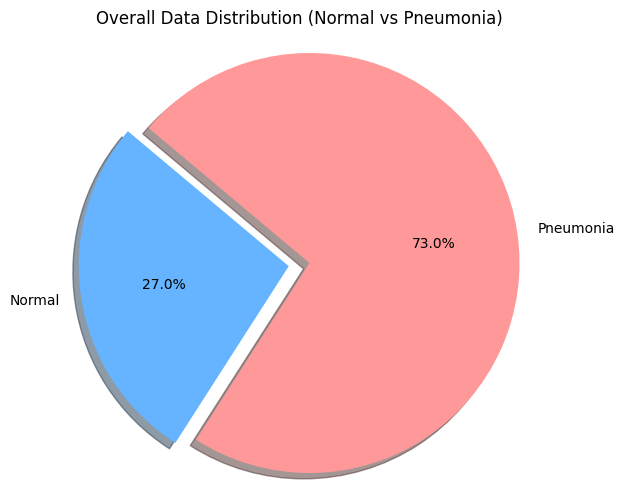

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np

def plot_data_distribution_pie(train_dir, val_dir, test_dir):
    normal_train = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
    pneumonia_train = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
    normal_val = len(os.listdir(os.path.join(val_dir, 'NORMAL')))
    pneumonia_val = len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))
    normal_test = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
    pneumonia_test = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))

    # Calculate the total counts for Normal and Pneumonia
    total_normal = normal_train + normal_val + normal_test
    total_pneumonia = pneumonia_train + pneumonia_val + pneumonia_test

    # Pie chart data
    labels = ['Normal', 'Pneumonia']
    sizes = [total_normal, total_pneumonia]
    colors = ['#66b3ff', '#ff9999']
    explode = (0.1, 0)  # "explode" the first slice (Normal)

    # Plot pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

    plt.title('Overall Data Distribution (Normal vs Pneumonia)')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

# Plot data distribution as a pie chart for Normal vs Pneumonia
plot_data_distribution_pie(train_dir, val_dir, test_dir)


# Earlystopping callback

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Add EarlyStopping callback to stop training when the validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Number of epochs with no improvement after which training will stop
    restore_best_weights=True,  # Restore the model weights from the epoch with the best value of the monitored metric
    verbose=1
)

###  Model Building and Training
#### Base Models
- Pre-trained models: DenseNet121, EfficientNetB0, ResNet50.
- Layers are added to each base model:
  - `GlobalAveragePooling2D`
  - Fully connected layer with 1024 units and ReLU activation.
  - Output layer with 1 unit and sigmoid activation for binary classification.

In [ ]:
def build_model(base_model):
    """
    Builds a binary classification model on top of a pre-trained base model.
    """
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Adds global average pooling to reduce dimensions
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

#### Model Compilation and Training
- Loss Function: Binary Crossentropy.
- Optimizer: Adam with a learning rate of `0.0001`.
- Metrics: Accuracy.
- Callback: EarlyStopping to monitor validation loss and stop training if no improvement is observed for 5 epochs.

In [ ]:
import matplotlib.pyplot as plt

def compile_and_train_model(model, model_name, learning_rate=0.0001, epochs=30):
    """
    Compiles, trains, and plots metrics for a given model.
    """
    # Define EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model with EarlyStopping callback
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=[early_stopping]
    )


    # Plot training and validation metrics
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model


# Initialize base models with pre-trained ImageNet weights

In [ ]:
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Build models for each architecture

In [ ]:
model_densenet = build_model(base_model_densenet)
model_efficientnet = build_model(base_model_efficientnet)
model_resnet = build_model(base_model_resnet)

# Display model summaries for all models

In [ ]:
model_densenet.summary()
model_efficientnet.summary()
model_resnet.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 8,088,129 (30.85 MB)

 Trainable params: 8,004,481 (30.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 5,362,340 (20.46 MB)

 Trainable params: 5,320,317 (20.30 MB)

 Non-trainable params: 42,023 (164.16 KB)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 25,633,793 (97.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

# Train DenseNet model, visualize and  Model Saving
- Trained models are saved in `.keras` format to Google Drive.

Training DenseNet Model...
Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 877s 4s/step - accuracy: 0.8979 - loss: 0.2424 - val_accuracy: 0.7500 - val_loss: 0.8909
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 156s 924ms/step - accuracy: 0.9475 - loss: 0.1270 - val_accuracy: 0.8750 - val_loss: 0.4171
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 197s 885ms/step - accuracy: 0.9642 - loss: 0.0903 - val_accuracy: 0.9375 - val_loss: 0.1428
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 202s 895ms/step - accuracy: 0.9702 - loss: 0.0810 - val_accuracy: 0.9375 - val_loss: 0.1136
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 152s 891ms/step - accuracy: 0.9747 - loss: 0.0685 - val_accuracy: 1.0000 - val_loss: 0.0779
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 204s 914ms/step - accuracy: 0.9729 - loss: 0.0678 - val_accuracy: 1.0000 - val_loss: 0.0430
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 215s 985ms/step - accuracy: 0.9779 - loss: 0.0640 - val_accuracy: 1.0000 - val_loss: 0.0872
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 161s 939ms/s

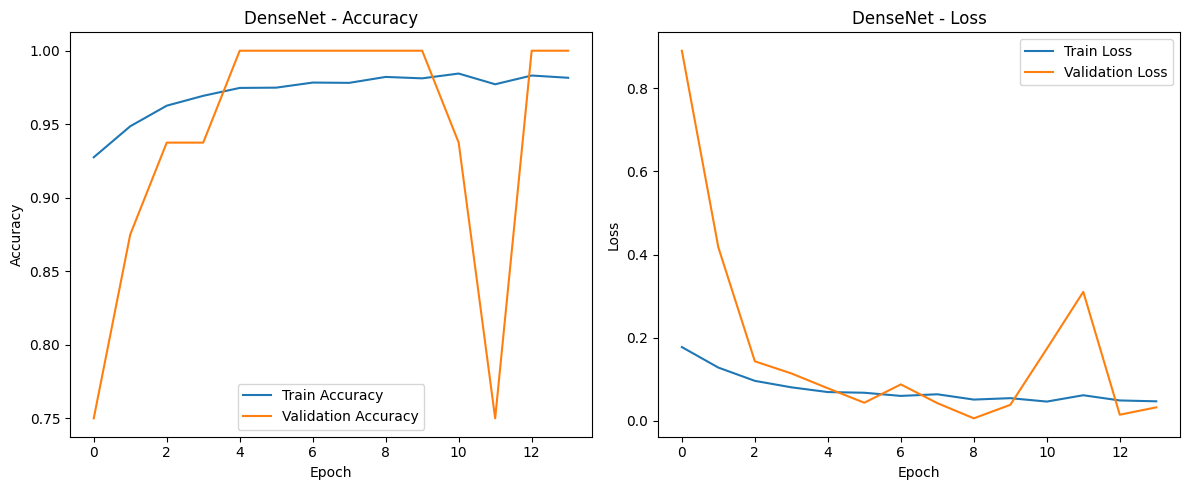

DenseNet model saved to Google Drive.


In [ ]:
# Train DenseNet model and visualize training
print("Training DenseNet Model...")
model_densenet = compile_and_train_model(model_densenet, 'DenseNet', learning_rate=0.0001, epochs=30)

# Save the trained DenseNet model to Google Drive
model_densenet.save('/content/drive/MyDrive/DenseNet_final_model.keras')  # Save in .keras format
print("DenseNet model saved to Google Drive.")



# Train EfficientNet model, visualize and  Model Saving**
- Trained models are saved in `.keras` format to Google Drive.

Training EfficientNet Model...
Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 245s 909ms/step - accuracy: 0.8493 - loss: 0.3285 - val_accuracy: 0.5625 - val_loss: 0.7808
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 213s 934ms/step - accuracy: 0.9517 - loss: 0.1361 - val_accuracy: 0.5000 - val_loss: 1.1781
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 146s 853ms/step - accuracy: 0.9541 - loss: 0.1108 - val_accuracy: 0.5000 - val_loss: 2.4057
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 849ms/step - accuracy: 0.9640 - loss: 0.0868 - val_accuracy: 0.6875 - val_loss: 0.5302
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 205s 859ms/step - accuracy: 0.9681 - loss: 0.0836 - val_accuracy: 0.8750 - val_loss: 0.2558
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 138s 814ms/step - accuracy: 0.9784 - loss: 0.0571 - val_accuracy: 1.0000 - val_loss: 0.0549
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 144s 828ms/step - accuracy: 0.9754 - loss: 0.0670 - val_accuracy: 0.9375 - val_loss: 0.0964
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 

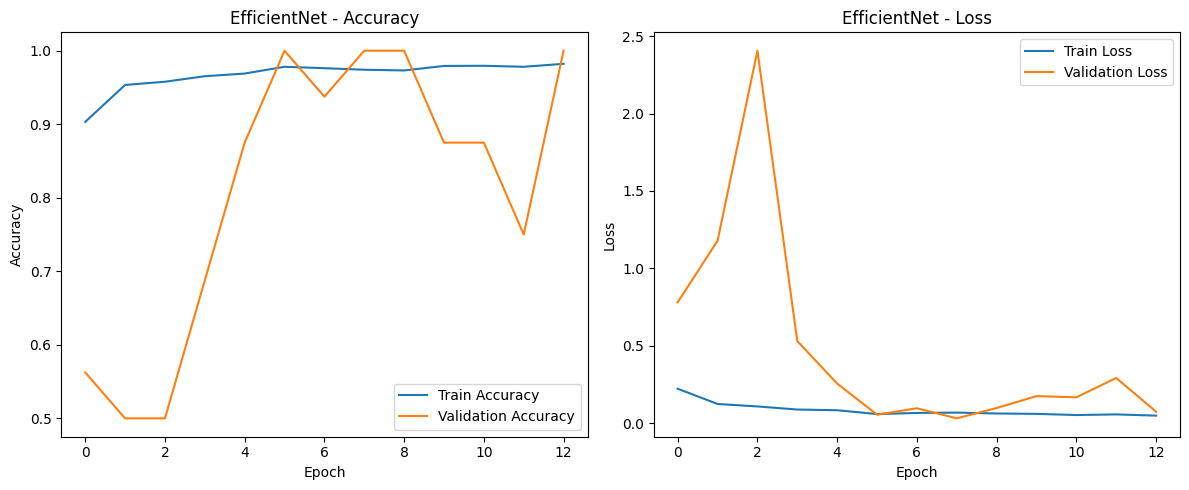

EfficientNet model saved to Google Drive.


In [ ]:
# Train EfficientNet model and visualize training
print("Training EfficientNet Model...")
model_efficientnet = compile_and_train_model(model_efficientnet, 'EfficientNet', learning_rate=0.0001, epochs=30)

# Save the trained EfficientNet model to Google Drive
model_efficientnet.save('/content/drive/MyDrive/EfficientNet_final_model.keras')  # Save in .keras format
print("EfficientNet model saved to Google Drive.")


# Train ResNet model, visualize and  Model Saving**
- Trained models are saved in `.keras` format to Google Drive.

Training ResNet Model...
Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 223s 933ms/step - accuracy: 0.8840 - loss: 0.2724 - val_accuracy: 0.5000 - val_loss: 0.9357
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 167s 921ms/step - accuracy: 0.9473 - loss: 0.1282 - val_accuracy: 0.3750 - val_loss: 0.8054
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 196s 889ms/step - accuracy: 0.9619 - loss: 0.1022 - val_accuracy: 0.5000 - val_loss: 1.6334
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 212s 949ms/step - accuracy: 0.9706 - loss: 0.0761 - val_accuracy: 0.5000 - val_loss: 5.9751
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 196s 911ms/step - accuracy: 0.9677 - loss: 0.0865 - val_accuracy: 0.5000 - val_loss: 9.7571
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 204s 931ms/step - accuracy: 0.9753 - loss: 0.0781 - val_accuracy: 0.5000 - val_loss: 2.4017
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 150s 887ms/step - accuracy: 0.9750 - loss: 0.0685 - val_accuracy: 0.7500 - val_loss: 0.3367
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 206s 907ms/

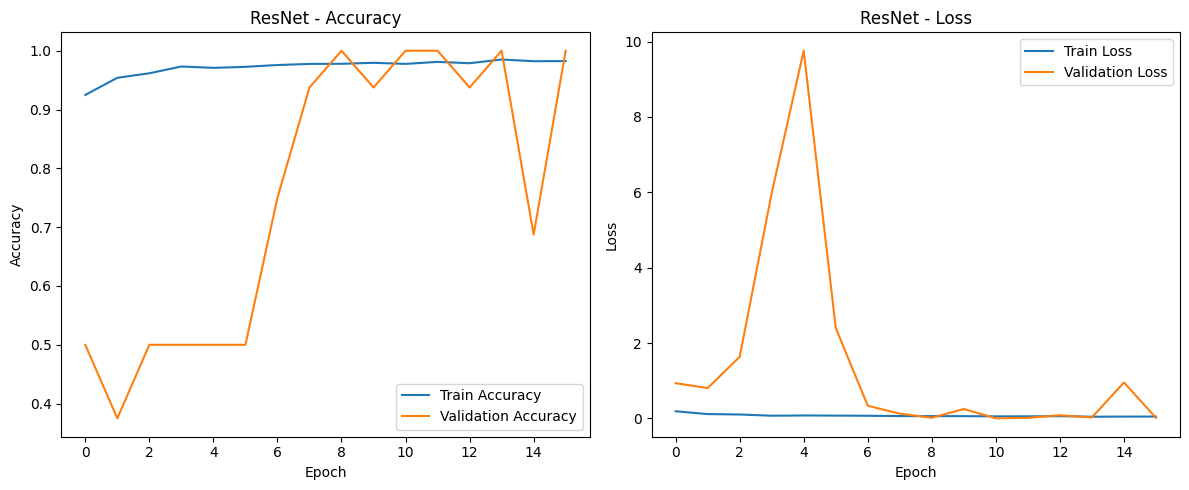

ResNet model saved to Google Drive.


In [ ]:
# Train ResNet model and visualize training
print("Training ResNet Model...")
model_resnet = compile_and_train_model(model_resnet, 'ResNet', learning_rate=0.0001, epochs=30)

# Save the trained ResNet model to Google Drive
model_resnet.save('/content/drive/MyDrive/ResNet_final_model.keras')  # Save in .keras format
print("ResNet model saved to Google Drive.")

# Evaluate each model on the test set to check generalization

In [ ]:
def evaluate_model(model, model_name):
    """
    Evaluates a trained model on the test set and prints results.
    """
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"{model_name} Test Accuracy: {test_acc*100:.2f}%")
    print(f"{model_name} Test Loss: {test_loss:.4f}")

# Evaluate all models
evaluate_model(model_densenet, 'DenseNet')
evaluate_model(model_efficientnet, 'EfficientNet')
evaluate_model(model_resnet, 'ResNet')

20/20 ━━━━━━━━━━━━━━━━━━━━ 238s 12s/step - accuracy: 0.9110 - loss: 0.2497
DenseNet Test Accuracy: 90.22%
DenseNet Test Loss: 0.2821
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 370ms/step - accuracy: 0.9250 - loss: 0.1994
EfficientNet Test Accuracy: 92.95%
EfficientNet Test Loss: 0.1947
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 340ms/step - accuracy: 0.8980 - loss: 0.3212
ResNet Test Accuracy: 88.94%
ResNet Test Loss: 0.3506



### Fine-Tuning
- Layer Freezing: Freeze all layers except the last 4 to fine-tune pre-trained weights.
- Fine-Tuning Training: Train with a lower learning rate (`0.00001`) for additional epochs to improve performance.
- Model Saving: Fine-tuned models are saved to Google Drive.

# Importing libraries and loading saved models, Defining path, Image size, Batch size and Test generator

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

# Load the previously saved models
densenet_model_path = '/content/drive/MyDrive/DenseNet_final_model.keras'
efficientnet_model_path = '/content/drive/MyDrive/EfficientNet_final_model.keras'
resnet_model_path = '/content/drive/MyDrive/ResNet_final_model.keras'

model_densenet = load_model(densenet_model_path)
model_efficientnet = load_model(efficientnet_model_path)
model_resnet = load_model(resnet_model_path)

# Define the path to your chest_xray dataset
base_dir = '/content/drive/MyDrive/chest_xray/chest_xray'

# Path to training, validation, and test directories
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')  # Path to the test data

# Set image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Prepare the ImageDataGenerator for rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a test generator to load the images from the test directory
test_generator = test_datagen.flow_from_directory(
    test_dir,              # Path to the test directory
    target_size=IMG_SIZE,  # Resize images to the specified size
    batch_size=BATCH_SIZE, # Batch size
    class_mode='binary',   # Binary classification (Normal vs Pneumonia)
    shuffle=False          # Do not shuffle as we need to align with ground truth
)

Found 624 images belonging to 2 classes.


# Freezing & Unfreezing layers and compile

In [ ]:
# Fine-tune the model by freezing layers
def fine_tune_model(model, learning_rate=0.00001, epochs=5, model_name="model"):
    """
    Fine-tune the model by unfreezing some top layers.
    Args:
        model: The model to fine-tune.
        learning_rate: Learning rate for fine-tuning.
        epochs: Number of epochs to fine-tune.
        model_name: The name of the model to save.
    """
    # Unfreeze the last few layers for fine-tuning
    for layer in model.layers[:-4]:  # Freeze all layers except the last 4
        layer.trainable = False
    for layer in model.layers[-4:]:
        layer.trainable = True

    # Compile and fine-tune the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Fine-tune the model for additional epochs
    history = model.fit(test_generator, epochs=epochs, validation_data=test_generator)

    # Save the fine-tuned model
    model_save_path = f"/content/drive/MyDrive/{model_name}_fine_tuned.keras"
    model.save(model_save_path)
    print(f"Fine-tuned {model_name} model saved to: {model_save_path}")

    return model, history

### Evaluation
- Classification Metrics:
  - Test accuracy and loss.
  - Classification report (Precision, Recall, F1-Score).
  - Confusion matrix.
- Threshold Adjustment: Evaluate models with adjusted thresholds (e.g., 0.3) to observe changes in performance.
- ROC Curve and AUC Score: Visualize model performance over varying thresholds.

In [ ]:

# Evaluate the model using a custom threshold
def evaluate_model(model, test_generator, model_name, threshold=0.5):
    """
    Evaluates the model on the test data and generates various metrics like classification report,
    confusion matrix, and ROC curve.

    Args:
    - model: The trained model
    - test_generator: The data generator for the test data
    - model_name: The name of the model (for display purposes)
    - threshold: The threshold for classification (default: 0.5)
    """
    # Get true labels
    y_true = test_generator.classes

    # Get predicted probabilities
    y_pred_prob = model.predict(test_generator, verbose=1)

    # Convert probabilities to binary predictions using the threshold
    y_pred = (y_pred_prob > threshold).astype(int).flatten()

    # Classification Report
    print(f"{model_name} Classification Report (Threshold: {threshold}):")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ROC Curve and AUC Score
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

#Training

In [ ]:
#  Fine-tune the DenseNet model and evaluate
print("Fine-tuning DenseNet Model...")
model_densenet, history_densenet = fine_tune_model(model_densenet, model_name="DenseNet")

#  Fine-tune the EfficientNet model and evaluate
print("Fine-tuning EfficientNet Model...")
model_efficientnet, history_efficientnet = fine_tune_model(model_efficientnet, model_name="EfficientNet")

#  Fine-tune the ResNet model and evaluate
print("Fine-tuning ResNet Model...")
model_resnet, history_resnet = fine_tune_model(model_resnet, model_name="ResNet")



Fine-tuning DenseNet Model...
Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9331 - loss: 0.1962 - val_accuracy: 0.9038 - val_loss: 0.2692
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 660ms/step - accuracy: 0.8884 - loss: 0.3470 - val_accuracy: 0.9038 - val_loss: 0.2613
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 807ms/step - accuracy: 0.8644 - loss: 0.3890 - val_accuracy: 0.9087 - val_loss: 0.2548
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 655ms/step - accuracy: 0.8789 - loss: 0.3178 - val_accuracy: 0.9119 - val_loss: 0.2496
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 637ms/step - accuracy: 0.8910 - loss: 0.3009 - val_accuracy: 0.9151 - val_loss: 0.2442
Fine-tuned DenseNet model saved to: /content/drive/MyDrive/DenseNet_fine_tuned.keras
Fine-tuning EfficientNet Model...
Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.6675 - loss: 1834306.0000 - val_accuracy: 0.6250 - val_loss: 989264.3125
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 53s 637ms/step - accuracy: 0.6737 - loss:

### Comprehensive Evaluation
- Evaluate all models (DenseNet, EfficientNet, ResNet) on the test set using various thresholds.
- Generate classification metrics, confusion matrices, and ROC curves for deeper insights.

Evaluating DenseNet with adjusted threshold 0.3:
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 885ms/step
DenseNet Classification Report (Threshold: 0.3):
              precision    recall  f1-score   support

      Normal       0.92      0.85      0.88       234
   Pneumonia       0.91      0.95      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.90      0.91       624
weighted avg       0.91      0.91      0.91       624



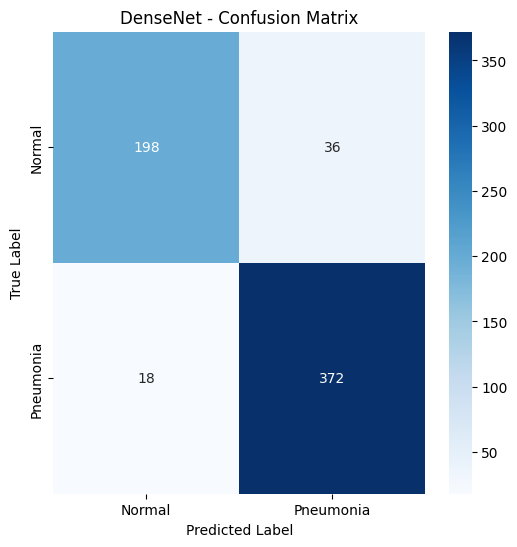

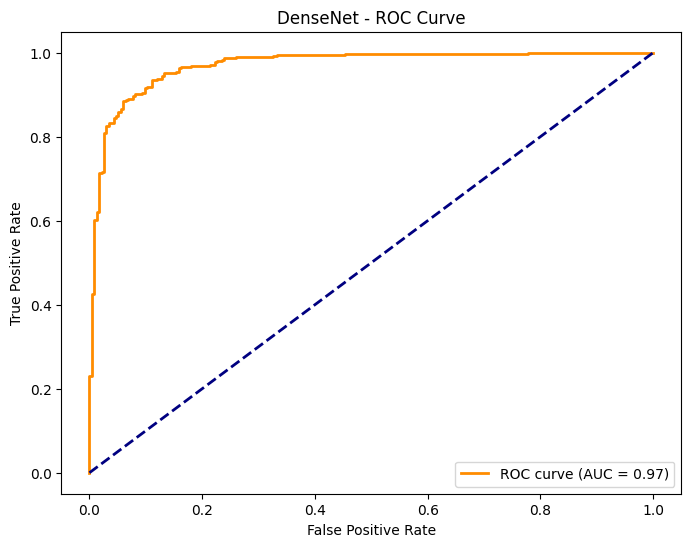

Evaluating EfficientNet with adjusted threshold 0.3:
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 646ms/step
EfficientNet Classification Report (Threshold: 0.3):
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00       234
   Pneumonia       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



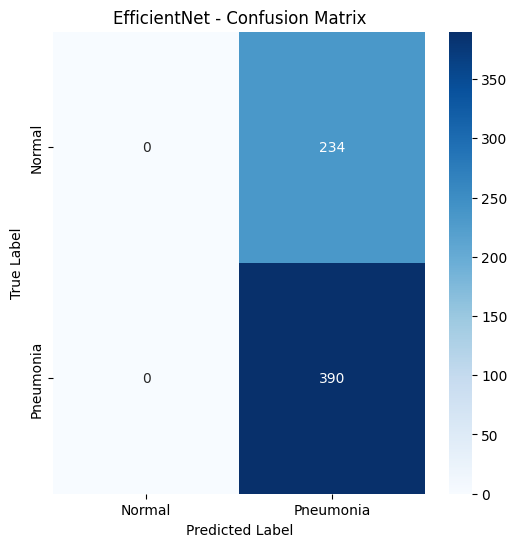

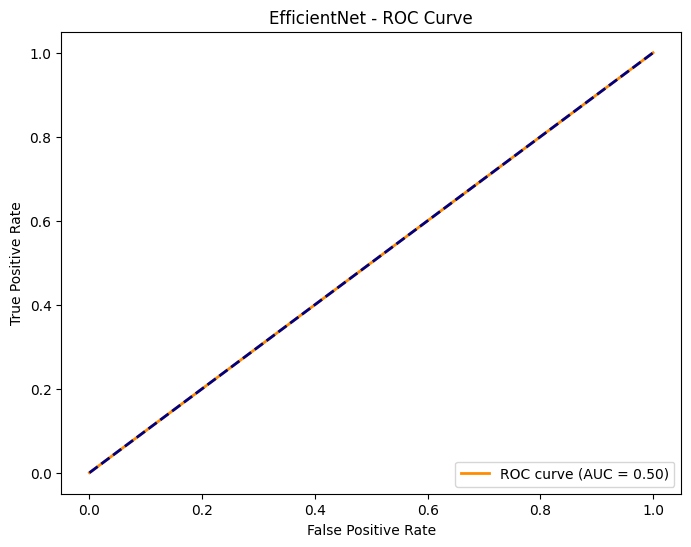

Evaluating ResNet with adjusted threshold 0.3:
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 450ms/step
ResNet Classification Report (Threshold: 0.3):
              precision    recall  f1-score   support

      Normal       0.95      0.75      0.84       234
   Pneumonia       0.87      0.98      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.86      0.88       624
weighted avg       0.90      0.89      0.89       624



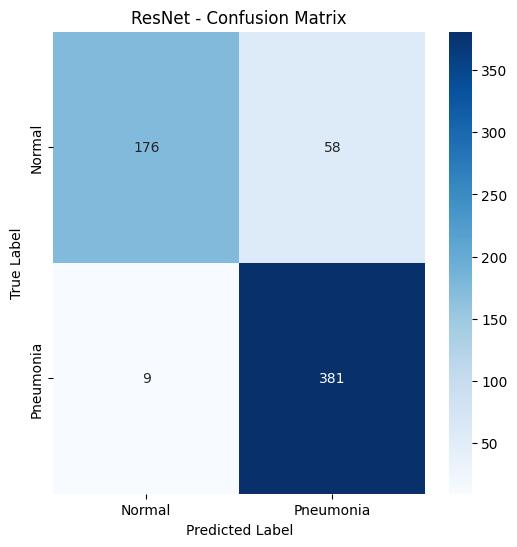

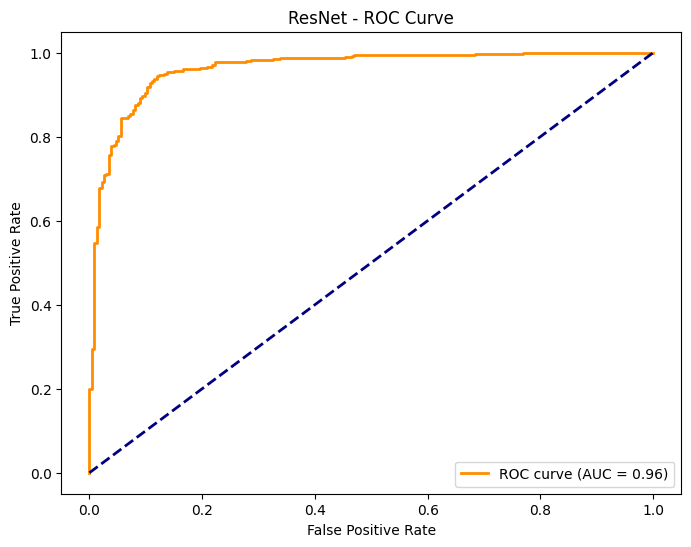

In [ ]:
#Evaluate models with adjusted threshold (e.g., 0.3)

print("Evaluating DenseNet with adjusted threshold 0.3:")
evaluate_model(model_densenet, test_generator, 'DenseNet', threshold=0.3)

print("Evaluating EfficientNet with adjusted threshold 0.3:")
evaluate_model(model_efficientnet, test_generator, 'EfficientNet', threshold=0.3)

print("Evaluating ResNet with adjusted threshold 0.3:")
evaluate_model(model_resnet, test_generator, 'ResNet', threshold=0.3)


# Model Evaluation without fine tuning

# Importing libraries and loading saved models

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, average_precision_score

# Load the previously saved models
densenet_model_path = '/content/drive/MyDrive/DenseNet_final_model.keras'
efficientnet_model_path = '/content/drive/MyDrive/EfficientNet_final_model.keras'
resnet_model_path = '/content/drive/MyDrive/ResNet_final_model.keras'

# Load the DenseNet, EfficientNet, and ResNet models from the saved .keras files
model_densenet = load_model(densenet_model_path)
model_efficientnet = load_model(efficientnet_model_path)
model_resnet = load_model(resnet_model_path)

# Defining path, Image size, Batch size and Test generator

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to your chest_xray dataset
base_dir = '/content/drive/MyDrive/chest_xray/chest_xray'

# Path to training, validation, and test directories
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Set image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Prepare the ImageDataGenerator for rescaling and augmenting the data
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a test generator to load the images from the test directory
test_generator = test_datagen.flow_from_directory(
    test_dir,              # Path to the test directory
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',   # Binary classification (Normal vs Pneumonia)
    shuffle=False          # Do not shuffle as we need to align with ground truth
)


Found 624 images belonging to 2 classes.


# Evaluation

In [ ]:
# Define a function to evaluate the model and visualize results
def evaluate_model(model, test_generator, model_name, threshold=0.5):
    """
    Evaluates the model on the test data and generates various metrics like classification report,
    confusion matrix, and ROC curve.

    Args:
    - model: The trained model
    - test_generator: The data generator for the test data
    - model_name: The name of the model (for display purposes)
    - threshold: The threshold for classification (default: 0.5)
    """
    # Get true labels
    y_true = test_generator.classes

    # Get predicted probabilities
    y_pred_prob = model.predict(test_generator, verbose=1)

    # Convert probabilities to binary predictions using the threshold
    y_pred = (y_pred_prob > threshold).astype(int).flatten()

    # Classification Report
    print(f"{model_name} Classification Report (Threshold: {threshold}):")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ROC Curve and AUC Score
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 243s 12s/step
DenseNet Classification Report (Threshold: 0.5):
              precision    recall  f1-score   support

      Normal       0.84      0.91      0.87       234
   Pneumonia       0.94      0.90      0.92       390

    accuracy                           0.90       624
   macro avg       0.89      0.90      0.90       624
weighted avg       0.90      0.90      0.90       624



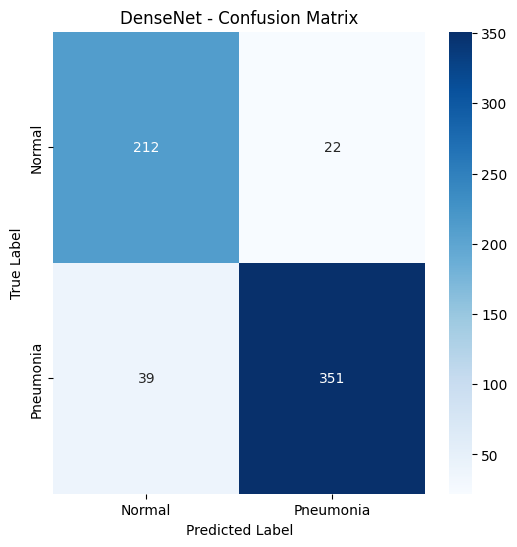

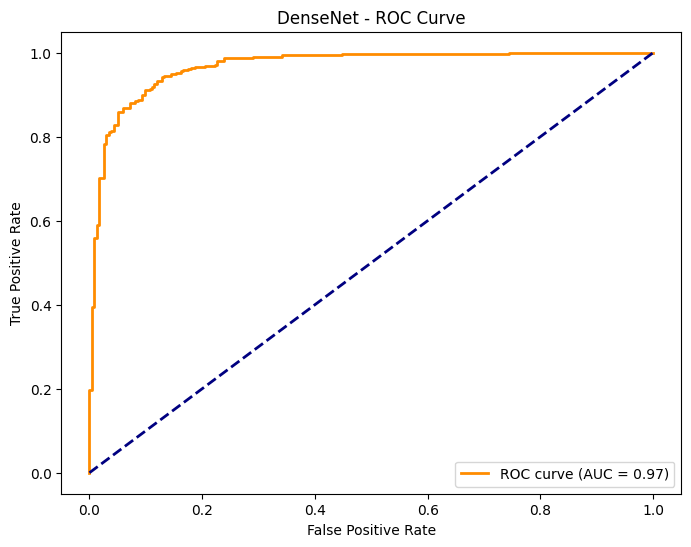

20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 793ms/step
EfficientNet Classification Report (Threshold: 0.5):
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00       234
   Pneumonia       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



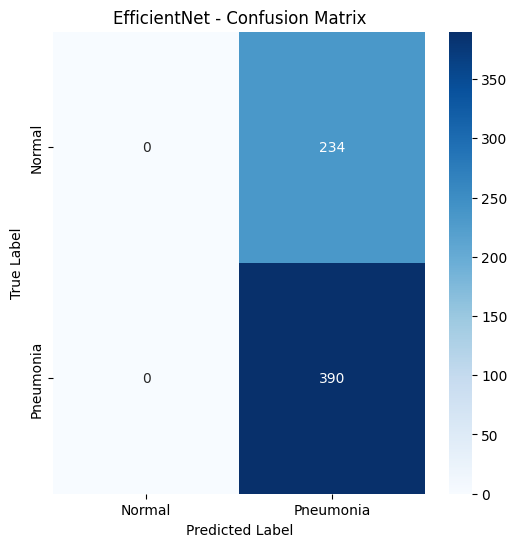

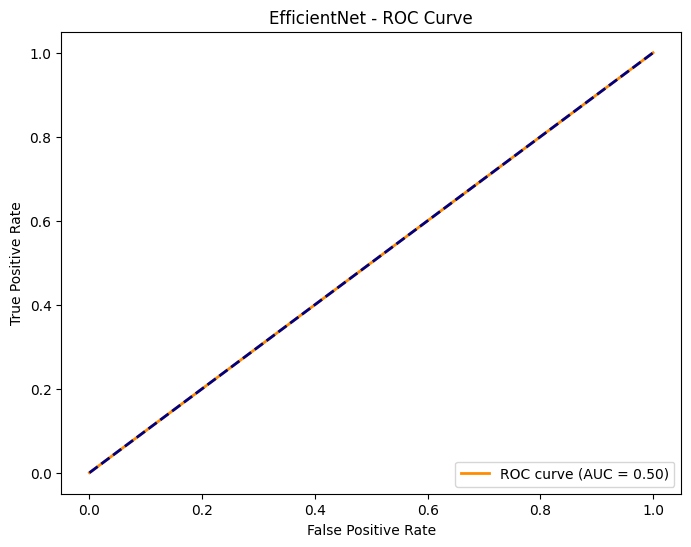

20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 562ms/step
ResNet Classification Report (Threshold: 0.5):
              precision    recall  f1-score   support

      Normal       0.91      0.79      0.84       234
   Pneumonia       0.88      0.95      0.91       390

    accuracy                           0.89       624
   macro avg       0.89      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624



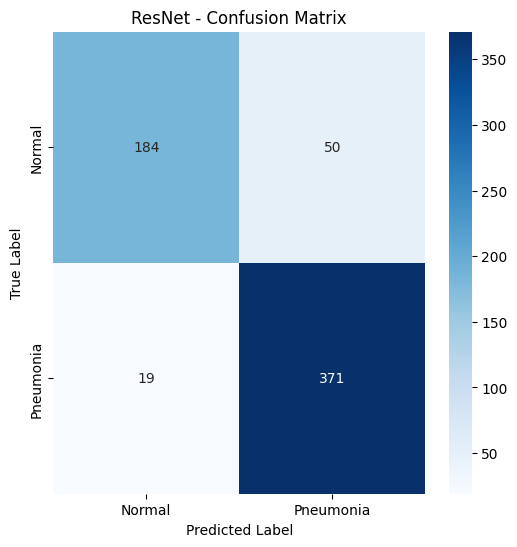

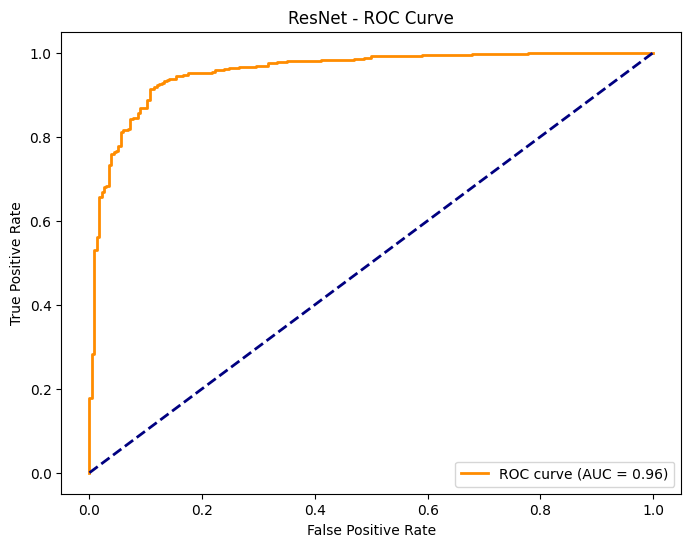

In [ ]:
# Evaluate all three models
evaluate_model(model_densenet, test_generator, 'DenseNet', threshold=0.5)
evaluate_model(model_efficientnet, test_generator, 'EfficientNet', threshold=0.5)
evaluate_model(model_resnet, test_generator, 'ResNet', threshold=0.5)

##  Grad-CAM for Explainability and Heatmap

In [ ]:
import tensorflow as tf
import numpy as np

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    """
    Generate Grad-CAM heatmap to visualize model focus.
    Args:
        img_array: Preprocessed input image array.
        model: Trained model.
        last_conv_layer_name: Name of the last convolutional layer.
    Returns:
        Heatmap indicating areas of model focus.
    """
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = np.mean(grads, axis=(0, 1))  # Compute average gradient per channel
    conv_outputs = conv_outputs[0]  # Get the output of the last convolutional layer for the image

    # Reshape pooled_grads to [1, 1, channels] for broadcasting
    pooled_grads = pooled_grads[np.newaxis, np.newaxis, :]  # Shape: [1, 1, channels]

    # Element-wise multiplication using broadcasting
    conv_outputs = conv_outputs * pooled_grads  # Broadcasting happens here

    heatmap = np.mean(conv_outputs, axis=-1)  # Average across channels to get the heatmap
    heatmap = np.maximum(heatmap, 0)  # Remove negative values (we only care about positive importance)
    heatmap = heatmap / np.max(heatmap)  # Normalize the heatmap to [0, 1]

    return heatmap


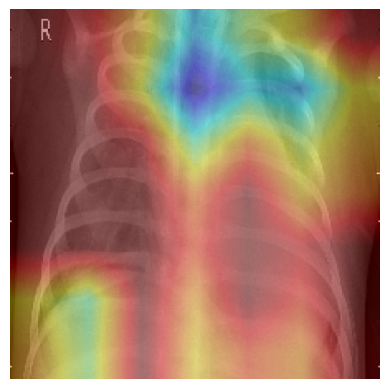

In [ ]:
import matplotlib.pyplot as plt
import cv2

def display_gradcam(img_array, model, last_conv_layer_name, class_index):
    """
    Displays Grad-CAM heatmap overlayed on input image.
    Args:
        img_array: Preprocessed image array.
        model: Trained model.
        last_conv_layer_name: Last convolution layer name.
        class_index: Index of the class to visualize.
    """
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Rescale heatmap to range [0, 255]
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))
    heatmap = np.uint8(255 * heatmap)

    # Apply a colormap to the heatmap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert the input image to RGB
    img_array_rgb = img_array[0] * 255  # Reverse the preprocessing

    # Overlay the heatmap on the image
    superimposed_img = cv2.addWeighted(img_array_rgb.astype(np.uint8), 0.6, heatmap, 0.4, 0)

    # Display the image
    plt.imshow(superimposed_img)
    plt.axis('off')  # No axes for the image
    plt.show()

# Example usage:
img, label = next(test_generator)  # Fetch a batch using the built-in next() method
sample_img = np.expand_dims(img[0], axis=0)  # Take one image from the batch
display_gradcam(sample_img, model_densenet, 'conv5_block16_2_conv', class_index=1)
